<a href="https://colab.research.google.com/github/chrisandoryan/Camstroke-Inference/blob/main/Camstroke_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Declaration

In [15]:
from math import log
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import os
import pickle
import shlex

from sklearn.model_selection import GroupShuffleSplit
from imblearn.under_sampling import RandomUnderSampler

# Model Builder

In [2]:
latent_dim = 256  # Latent dimensionality of the encoding space.

def build_models(num_encoder_tokens, num_decoder_tokens):
    """
    ## Build the model
    """

    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, dropout=0.2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # dropout = keras.layers.Dropout(rate=0.2)
    # decoder_outputs = dropout(decoder_outputs)
    
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

def load_models(path):
    """
    ## Run inference (sampling)

    1. encode input and retrieve initial decoder state
    2. run one step of decoder with this initial state
    and a "start of sequence" token as target.
    Output will be the next target token.
    3. Repeat with the current target token and current states
    """

    # Define sampling models
    # Restore the model and construct the encoder and decoder.
    model = keras.models.load_model(path)
    model.summary()

    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_7")
    decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_8")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[4]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

    return model, encoder_model, decoder_model

# Training and Evaluation Preparation

## Parameter Configuration

In [3]:
batch_size = 32  # Batch size for training.
epochs = 100  # Number of epochs to train for.

START_TOKEN = "\t"
END_TOKEN = "\n"

## Training Utilities

In [4]:
def prepare(datasets, keydelay_tokens, keytext_tokens):
    # Vectorize the data.
    keydelay_inputs = []
    keytext_targets = []
    keydelay_tokens = sorted(list(keydelay_tokens))
    keytext_tokens = [START_TOKEN, END_TOKEN] + list(keytext_tokens)
    keytext_tokens = sorted(list(keytext_tokens))
    num_encoder_tokens = max(keydelay_tokens) + 1
    num_decoder_tokens = len(keytext_tokens)

    for d in datasets:
        # train_df, test_df = np.split(d, [int(.9*len(d))])
        keydelays = d['keydelay'].tolist()
        keytexts = d['key2'].tolist()
        keytexts = [START_TOKEN] + keytexts + [END_TOKEN]

        keydelays = to_categorical(keydelays, num_classes=num_encoder_tokens)
        keydelay_inputs.append(keydelays)
        keytext_targets.append(keytexts)

    max_encoder_seq_length = max([len(i) for i in keydelay_inputs])
    max_decoder_seq_length = max([len(t) for t in keytext_targets])

    print("Number of samples:", len(keydelay_inputs))
    print("Number of unique input tokens:", num_encoder_tokens)
    print("Number of unique output tokens:", num_decoder_tokens)
    print("Max sequence length for inputs:", max_encoder_seq_length)
    print("Max sequence length for outputs:", max_decoder_seq_length)

    input_token_index = dict([(char, i)
                              for i, char in enumerate(keydelay_tokens)])
    target_token_index = dict([(char, i)
                               for i, char in enumerate(keytext_tokens)])

    # one-hot encoding
    encoder_input_data = np.zeros(
        (len(keydelay_inputs), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(keydelay_inputs), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(keydelay_inputs), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

    for i, (keydelay, keytext) in enumerate(zip(keydelay_inputs, keytext_targets)):
        encoder_input_data[i, 0:len(keydelay)] = keydelay

        for t, text in enumerate(keytext):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_token_index[text]] = 1.0
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_token_index[text]] = 1.0

        # what's this for?
        # i thinks this is to disregard the ' ' (on the tutorial they used target_token_index[' ']) so that the model won't predict it.
        # decoder_input_data[i, t + 1:, target_token_index['a']] = 1.0
        # decoder_target_data[i, t:, target_token_index['a']] = 1.0

    # print(encoder_input_data)
    print(encoder_input_data.shape)
    # print(decoder_input_data)
    print(decoder_input_data.shape)
    # print(decoder_target_data)
    print(decoder_target_data.shape)
    # input()

    # variables to be passed back for futher processing
    data = (encoder_input_data, decoder_input_data, decoder_target_data)
    tokens = (num_encoder_tokens, num_decoder_tokens)
    sequences = (max_encoder_seq_length, max_decoder_seq_length)
    indices = (input_token_index, target_token_index)

    return data, tokens, sequences, indices

def plot_training_performance(H):
    # construct a plot that plots and saves the training history
    N = np.arange(0, min(epochs, len(H.history["loss"])))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(f"{model_path}/loss_plot.png")

    # construct a plot that plots and saves the training history
    N = np.arange(0, min(epochs, len(H.history["accuracy"])))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["accuracy"], label="train_accuracy")
    plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(f"{model_path}/acc_plot.png")

    plt.show()

In [5]:
def generator(X_data, y_data, batch_size):
  samples_per_epoch = len(X_data)
  number_of_batches = samples_per_epoch / batch_size
  counter = 0

  while True:
    X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
    y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
    counter += 1
    yield X_batch,y_batch

    # restart counter to yield data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

def train(train_datasets, test_datasets, keydelay_tokens, keytext_tokens):
    data, tokens, sequences, indices = prepare(
        train_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data
    num_encoder_tokens, num_decoder_tokens = tokens
    max_encoder_seq_length, max_decoder_seq_length = sequences
    input_token_index, target_token_index = indices

    model = build_models(num_encoder_tokens, num_decoder_tokens)

    model.compile(
        optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    overfitCallback = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    history = model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[overfitCallback]
    )

    # history = model.fit_generator(
    #     generator([encoder_input_data, decoder_input_data], decoder_target_data, batch_size),
    #     epochs=epochs,
    #     steps_per_epoch = len(train_datasets) / batch_size,
    # )

    # Save model
    model.save(model_path)

    # Plot training loss and accuracy
    plot_training_performance(history)

    return model

## Inference Utilities

In [6]:
# https://www.kaggle.com/greatrxt/smartreply-word-level-seq2seq-with-beam-search
def generate_beam_predictions(input_seq, n_next_sequences, beam_search_n, break_at_eos, models, tokens, indices):
    model, encoder_model, decoder_model = models
    num_encoder_tokens, num_decoder_tokens = tokens
    input_token_index, target_token_index = indices

    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char)
                                    for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char)
                                     for char, i in target_token_index.items())

    distributions_scores_states = [[list(), 0.0, [None, None]]]
    decoder_states_value = None

    for _ in range(n_next_sequences):
        sequence_temp_candidates = list()
        for i in range(len(distributions_scores_states)):
            # Generate empty target sequence of length 1.
            target_seq = np.zeros((1, 1, num_decoder_tokens))

            seq, score, states_values = distributions_scores_states[i]

            if len(distributions_scores_states) == 1:
                # Encode the input as state vectors.
                decoder_states_value = encoder_model.predict(input_seq)

                # Populate the first character of target sequence with the start character.
                target_seq[0, 0, target_token_index[START_TOKEN]] = 1.0
            else:
                target_seq[0, 0, seq[-1]] = 1.0
                decoder_states_value = states_values

                candidate_sentence = ""
                for token_index in seq:
                    word = reverse_target_char_index[token_index]
                    # print("Token Index", token_index)
                    # print("Char", word)
                    if word == END_TOKEN:
                        break

                    candidate_sentence += word

                print("score :", score, " | ", candidate_sentence)

            output_tokens_distribution, h, c = decoder_model.predict([target_seq] + decoder_states_value)
            # print("OutputTokens", output_tokens_distribution)

            # Update states
            decoder_states_value = [h, c]

            predicted_distribution = output_tokens_distribution[0][-1]

            for j in range(len(predicted_distribution)):
                # print("J", j)
                # print("PREDIST", predicted_distribution[j])
                if predicted_distribution[j] > 0:
                    candidate = [seq + [j], score - log(predicted_distribution[j]), decoder_states_value]
                    # print(candidate)
                    # input()
                    if break_at_eos and j == END_TOKEN:
                        continue
                    else:
                        sequence_temp_candidates.append(candidate)

        # 2. score and sort all candidates
        # print("SEQTEMP", sequence_temp_candidates[:beam_search_n])
        ordered = sorted(sequence_temp_candidates, key=lambda tup: tup[1], reverse=False) 
        # print("ORDERED", ordered[:beam_search_n])
        distributions_scores_states = ordered[:beam_search_n]
        # print("DIST", distributions_scores_states)
        # input()
        print("-----")

def decode_sequence(models, input_seq, num_decoder_tokens, max_decoder_seq_length, input_token_index, target_token_index):
    model, encoder_model, decoder_model = models

    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char)
                                    for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char)
                                     for char, i in target_token_index.items())

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[START_TOKEN]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        # print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == END_TOKEN or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]

    return decoded_sentence

## Inference Functions

In [7]:
def inference(test_datasets, keydelay_tokens, keytext_tokens):
    models = load_models(model_path)
    data, tokens, sequences, indices = prepare(
        test_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data
    num_encoder_tokens, num_decoder_tokens = tokens
    max_encoder_seq_length, max_decoder_seq_length = sequences
    input_token_index, target_token_index = indices

    total, correct = len(test_datasets), 0
    for i, d in enumerate(test_datasets):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data[i: i + 1]
        target_text = d['key2'].tolist()
        decoded_sentence = decode_sequence(
            models, input_seq, num_decoder_tokens, max_decoder_seq_length, input_token_index, target_token_index)
        print("-")
        print("Input sentence:", target_text)
        print("Decoded sentence:", decoded_sentence)
        if ''.join(target_text) == decoded_sentence.strip():
            correct += 1
            print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

    return

def beam_search_inference(test_datasets, keydelay_tokens, keytext_tokens):
    models = load_models(model_path)
    data, tokens, sequences, indices = prepare(
        test_datasets, keydelay_tokens, keytext_tokens)
    encoder_input_data, decoder_input_data, decoder_target_data = data

    for i, d in enumerate(test_datasets):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data[i: i + 1]
        target_text = d['key2'].tolist()
        print("Input sentence:", target_text)
        generate_beam_predictions(input_seq, n_next_sequences=len(target_text) + 1, beam_search_n=10, break_at_eos=True, models=models, tokens=tokens, indices=indices)
        input()

    return


## Dataset Utilities

In [17]:
def read_cmu_sessionmap():
    data_path = "./drive/MyDrive/S2/Thesis S2/CMU-SessionMap.txt"
    cols = ["user", "session_index", "key", "value"]
    
    with open(data_path, "r") as f:
        raw_data = f.read().splitlines()
        data = [shlex.split(r) for r in raw_data]
        df = pd.DataFrame(data[1:], columns=cols)
        return df

def split_dataset(df, datasets, word_dictionary):
    # shuffle the datasets
    random.shuffle(datasets)

    # Undersampling
    under_sampler = RandomUnderSampler(random_state=42)
    sampled_datasets, sampled_word_dictionary = under_sampler.fit_resample(datasets, word_dictionary)
    
    # split to train/test dataset with 80:20 ratio.
    train_datasets = sampled_datasets[:int(.80*len(sampled_datasets))]
    test_datasets = sampled_datasets[:int(.20*len(sampled_datasets))]

    keytext_tokens = df['key2'].unique()
    keydelay_tokens = df['keydelay'].unique()

    df = None
    return train_datasets, test_datasets, keytext_tokens, keydelay_tokens

def read_villani_dataset():
    data_path = "./drive/MyDrive/S2/Thesis S2/villani_keystrokes.csv"
    df = pd.read_csv(data_path, header=0)
    df['keydelay'] = df["timerelease"] - df["timepress"]
    df['key2'] = df["keyname"]

    return df
  
def read_cmu_dataset():
    data_path = "./drive/MyDrive/S2/Thesis S2/CMU-TimingFeatures-DD.txt"
    cols = ["subject_id", "session_index", "exercise_index", "digraph_index", "key1", "key2", "keydelay"]

    with open(data_path, "r") as f:
        raw_data = f.read().splitlines()
        data = [r.split() for r in raw_data]
        df = pd.DataFrame(data[1:], columns=cols)
        return df

def split_words_villani(df):
    chunk = []
    for i, d in df.iterrows():
        if len(d['keyname']) > 1:
            if len(chunk) > 1:
                chunk_df = pd.DataFrame(chunk)
                yield chunk_df
                chunk = []
        else:
            chunk.append(d.to_dict())

def split_words_cmu(df):
    chunk = []
    for i, d in df.iterrows():
        if len(d['key2']) > 1:
            if len(chunk) > 1:
                chunk_df = pd.DataFrame(chunk)
                yield chunk_df
                chunk = []
        else:
            chunk.append(d.to_dict())

def clean_dataset_villani(df):
    prune = ["inputtype","repetition","platform","gender","agegroup","handedness","awareness","location"]
    for p in prune:
        if p in df.columns:
            df.drop(p, axis=1, inplace=True)

def create_directory(directory):
  if not os.path.exists(directory):
      os.makedirs(directory)

def save_processed_dataset(data):
  path = f"{model_path}/camstroke-inference-dataset.dat"
  create_directory(model_path)
  with open(path, "wb") as f:
        return pickle.dump(data, f)

def load_processed_dataset(data):
    path = f"{model_path}/camstroke-inference-dataset.dat"
    create_directory(model_path)
    with open(path, "rb") as f:
        return pickle.load(f)

def read_rockyou_wordlist(n_data=50000):
    data_path = "./drive/MyDrive/S2/Thesis S2/rockyou.txt"
    with open(data_path, 'r', encoding='latin-1') as f:
        data = [r for r in f.read().splitlines()]
        if n_data > 0:
            data = data[:n_data] # Top n only
        df = pd.Series(data)
        df.columns = ['password']
        print(df.head())

    return df

def dfword_to_gram(df, n):
    for i in range(0, df.shape[0], n):
        yield df[max(0, i-1):i+n]
    # return np.array_split(df, n)
  
def make_balanced_dataset(dataset, word_dictionary, min_sample=1000):
    vc = pd.value_counts(np.array(word_dictionary))
    print(vc)
    for col_name, data in vc[(vc < min_sample)].items():
      # print(col_name, data, 'hehe')
      indices = [i for i, x in enumerate(word_dictionary) if x == col_name]
      for i, x in enumerate(indices):
        x = x - i
        word_dictionary.pop(x)
        dataset.pop(x)
    vc = pd.value_counts(np.array(word_dictionary))
    print(vc)

# Training Process

In [9]:
model_path = "./drive/MyDrive/S2/camstroke-inference-models/s2s_model_top100000rockyou_fixedtype_cleanwords_2"  # Path to store/load the model

In [10]:
def prepare_villani_dataset(mode="Free"):
    print("Reading and Preparing Villani Dataset...")
    df = read_villani_dataset()
    df.loc[df['keydelay'] >= 1000, 'keydelay'] = 1000

    # wl = read_rockyou_wordlist(n_data=100000)

    if mode == "Free":
      # freetext-mode only
      df = df[df["inputtype"] == "free"]
    elif mode == "Fixed":
      # fixed-text only
      df = df[df["inputtype"] == "fixed"]
    else:
      # all-text mode
      df = df[(df["inputtype"] == "fixed") & (df["inputtype"] == "free")]

    clean_dataset_villani(df)
    subjects = df.groupby('user')
    datasets = []
    word_dictionary = []

    for i, (subject_id, subject) in enumerate(subjects):
        sessions = subject.groupby("session")
        for sess_id, session in sessions:
            exercises = session.groupby("task")
            for exercise_id, exercise in exercises:
                print(f"Subject {i + 1}/{len(subjects)} | Session ID: {sess_id} | Exercise ID: {exercise_id}")
                print("Current Dataset Length: ", len(datasets))
                for exerchunk in split_words_villani(exercise):
                    word_chunk = "".join(exerchunk['key2'].tolist())
                    
                    # Mode 1: Get all word combinations
                    # print(word_chunk)
                    if len(word_chunk) < 5:
                        continue

                    datasets.append(exerchunk)
                    word_dictionary.append(word_chunk)

                    # Mode 2: Isolate to RockYou wordlist only
                    # if word_chunk in wl.values:
                    #     word_dictionary.append(word_chunk)
                    #     datasets.append(exerchunk)
                        # for gram in dfword_to_gram(exerchunk, 3):
                        #     # print(gram.head())
                        #     datasets.append(gram)

    return df, datasets, word_dictionary

def prepare_cmu_dataset(mode="Free"):
    print("Reading and Preparing CMU Dataset...")
    df = read_cmu_dataset()
    df['keydelay'] = df['keydelay'].apply(lambda x: int(float(x) * 1000)) # convert to miliseconds
    df.loc[df['keydelay'] >= 1000, 'keydelay'] = 1000

    sessionmap = read_cmu_sessionmap()

    gss = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)
    split = gss.split(df, groups=df["session_index"])
    train_indices, test_indices = next(split)
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    subjects = df.groupby('subject_id')
    datasets = []
    word_dictionary = []

    for subject_id, subject in subjects:
        sessions = subject.groupby("session_index")
        for sess_id, session in sessions:
            smap = sessionmap[(sessionmap["user"] == subject_id) & (sessionmap["session_index"] == sess_id)]
            smap_value = smap["value"].values[0]
            
            exercises = session.groupby("exercise_index")
            for exercise_id, exercise in exercises:
                text_mode = smap_value.split(" - ")[2]

                if mode == "Free":
                    if text_mode != "Free":
                        continue
                elif mode == "Fixed":
                    if text_mode != "Trans":
                        continue
                
                print(f"Subject ID: {subject_id} | Session ID: {sess_id} | Session Name: {smap_value} | Exercise ID: {exercise_id} | Mode: {text_mode}")
                print("Current Dataset Length: ", len(datasets))
                for exerchunk in split_words_cmu(exercise):
                    word_chunk = "".join(exerchunk['key2'].tolist())
                    
                    # Mode 1: Get all word combinations
                    # print(word_chunk)
                    if len(word_chunk) < 5:
                        continue

                    datasets.append(exerchunk)
                    word_dictionary.append(word_chunk)

                    # Mode 2: Isolate to RockYou wordlist only
                    # if word_chunk in wl.values:
                    #     word_dictionary.append(word_chunk)
                    #     datasets.append(exerchunk)
                        # for gram in dfword_to_gram(exerchunk, 3):
                        #     # print(gram.head())
                        #     datasets.append(gram)

    return df, datasets, word_dictionary

Load the datasets (from Villani and CMU, combined).

In [11]:
df1, dataset1, word_dictionary1 = prepare_villani_dataset(mode="Free")
df2, dataset2, word_dictionary2 = prepare_cmu_dataset(mode="Free")

Reading and Preparing Villani Dataset...
Subject 1/139 | Session ID: 447 | Exercise ID: freetext1
Current Dataset Length:  0
Subject 1/139 | Session ID: 558 | Exercise ID: freetext4
Current Dataset Length:  51
Subject 1/139 | Session ID: 1134 | Exercise ID: freetext4
Current Dataset Length:  102
Subject 1/139 | Session ID: 1288 | Exercise ID: freetext4
Current Dataset Length:  147
Subject 1/139 | Session ID: 1473 | Exercise ID: freetext4
Current Dataset Length:  193
Subject 2/139 | Session ID: 237 | Exercise ID: freetext1
Current Dataset Length:  231
Subject 2/139 | Session ID: 832 | Exercise ID: freetext1
Current Dataset Length:  283
Subject 2/139 | Session ID: 900 | Exercise ID: freetext1
Current Dataset Length:  329
Subject 2/139 | Session ID: 969 | Exercise ID: freetext1
Current Dataset Length:  372
Subject 3/139 | Session ID: 292 | Exercise ID: freetext7
Current Dataset Length:  414
Subject 3/139 | Session ID: 428 | Exercise ID: freetext7
Current Dataset Length:  458
Subject 3/139

In [18]:
df = pd.concat([df1, df2], join="inner", keys=["villani", "cmu"])
datasets = dataset1 + dataset2
word_dictionary = word_dictionary1 + word_dictionary2

# !-- Whole-dataset Inference Attack
make_balanced_dataset(datasets, word_dictionary, min_sample=50)
save_processed_dataset(datasets)
train_datasets, test_datasets, keytext_tokens, keydelay_tokens = split_dataset(df, datasets)

about         753
there         541
weekend       362
ihave         330
really        318
             ... 
slytherine      1
griffindor      1
ravenclaw       1
moreover        1
prouod          1
Length: 19483, dtype: int64
about       753
there       541
weekend     362
ihave       330
really      318
           ... 
write        50
least        50
spend        50
watching     50
coffee       50
Length: 147, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


ValueError: ignored

Number of samples: 12772
Number of unique input tokens: 1001
Number of unique output tokens: 168
Max sequence length for inputs: 11
Max sequence length for outputs: 13
(12772, 11, 1001)
(12772, 13, 168)
(12772, 13, 168)
Epoch 1/100
320/320 [==============================] - 7s 11ms/step - loss: 1.3625 - accuracy: 0.1413 - val_loss: 1.2998 - val_accuracy: 0.1644
Epoch 2/100
320/320 [==============================] - 3s 8ms/step - loss: 1.2346 - accuracy: 0.1868 - val_loss: 1.1717 - val_accuracy: 0.2078
Epoch 3/100
320/320 [==============================] - 3s 9ms/step - loss: 1.1553 - accuracy: 0.2120 - val_loss: 1.1206 - val_accuracy: 0.2290
Epoch 4/100
320/320 [==============================] - 3s 8ms/step - loss: 1.0989 - accuracy: 0.2289 - val_loss: 1.0548 - val_accuracy: 0.2415
Epoch 5/100
320/320 [==============================] - 3s 8ms/step - loss: 1.0584 - accuracy: 0.2397 - val_loss: 0.9936 - val_accuracy: 0.2680
Epoch 6/100
320/320 [==============================] - 3s 9ms/st

INFO:tensorflow:Assets written to: ./drive/MyDrive/S2/camstroke-inference-models/s2s_model_top100000rockyou_fixedtype_cleanwords_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/S2/camstroke-inference-models/s2s_model_top100000rockyou_fixedtype_cleanwords_2/assets


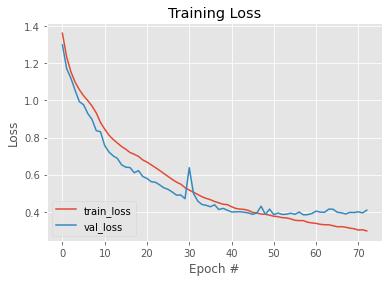

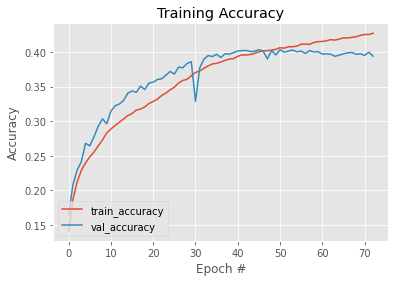

In [13]:
model = train(train_datasets, test_datasets, keydelay_tokens, keytext_tokens)

# Testing Process

In [14]:
# inference(test_datasets, keydelay_tokens, keytext_tokens)
beam_search_inference(test_datasets, keydelay_tokens, keytext_tokens)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1001)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 168)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        1288192     ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                 

KeyboardInterrupt: ignored